In [45]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import os
import types
import torch
import torch.nn as nn

In [46]:
# Import all libraries
import sys
sys.path.insert(1, 'H:\\IT_DUT\\Ki6\\PBL5\\Code_Test1\\Speech-Recognition-with-RNN-Neural-Networks\\utils')
import lib

In [47]:
DIR = os.path.abspath(os.getcwd())
DATASET_DIRECTORY_PATH = DIR+'/Data_Test/Thanh_clean'
train_audio_path =DATASET_DIRECTORY_PATH+"/"
labels = os.listdir(train_audio_path)

In [48]:
def load_weights(model, weights, PRINT=False):
    # Load weights into model.
    # If param's name is different, raise error.
    # If param's size is different, skip this param.
    # see: https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113/2
    
    for i, (name, param) in enumerate(weights.items()):
        model_state = model.state_dict()
        
        if name not in model_state:
            print("-"*80)
            print("weights name:", name) 
            print("RNN states names:", model_state.keys()) 
            assert 0, "Wrong weights file"
            
        model_shape = model_state[name].shape
        if model_shape != param.shape:
            print(f"\nWarning: Size of {name} layer is different between model and weights. Not copy parameters.")
            print(f"\tModel shape = {model_shape}, weights' shape = {param.shape}.")
        else:
            model_state[name].copy_(param)

In [49]:
def create_RNN_model(args, load_weights_from=None):
    ''' A wrapper for creating a 'class RNN' instance '''
    # Update some dependent args
    #args.num_classes = len(lib.read_list(args.classes_txt)) # read from "config/classes.names"
    args.num_classes = len(labels) # read from "config/classes.names"
    args.save_log_to = args.save_model_to + "log.txt"
    args.save_fig_to = args.save_model_to + "fig.jpg"
    
    # Create model
    device = args.device
    model = RNN(args.input_size, args.hidden_size, args.num_layers, args.num_classes, device).to(device)
    
    # Load weights
    if load_weights_from:
        print(f"Load weights from: {load_weights_from}")
        weights = torch.load(load_weights_from)
        load_weights(model, weights)
    
    return model

In [50]:
# Recurrent neural network (many-to-one)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, device, classes=None):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.device = device
        self.classes = classes

    def forward(self, x):
        # Set initial hidden and cell states
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device) 
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device) 
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # shape = (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

    def predict(self, x):
        '''Predict one label from one sample's features'''
        # x: feature from a sample, LxN
        #   L is length of sequency
        #   N is feature dimension
        x = torch.tensor(x[np.newaxis, :], dtype=torch.float32)
        x = x.to(self.device)
        outputs = self.forward(x)
        _, predicted = torch.max(outputs.data, 1)
        predicted_index = predicted.item()
        return predicted_index
    
    def set_classes(self, classes):
        self.classes = classes 
    
    def predict_audio_label(self, audio):
        idx = self.predict_audio_label_index(audio)
        assert self.classes, "Classes names are not set. Don't know what audio label is"
        label = self.classes[idx]
        return label

    def predict_audio_label_index(self, audio):
        audio.compute_mfcc()
        x = audio.mfcc.T # (time_len, feature_dimension)
        idx = self.predict(x)
        return idx


In [51]:
def set_default_args():
    
    args = types.SimpleNamespace()

    # model params
    args.input_size = 12  # == n_mfcc
    args.batch_size = 1
    args.hidden_size = 64
    args.num_layers = 3

    # training params
    args.num_epochs = 100
    args.learning_rate = 0.0001
    args.learning_rate_decay_interval = 5 # decay for every 5 epochs
    args.learning_rate_decay_rate = 0.5 # lr = lr * rate
    args.weight_decay = 0.00
    args.gradient_accumulations = 16 # number of gradient accums before step
    
    # training params2
    args.load_weights_from = None
    args.finetune_model = False # If true, fix all parameters except the fc layer
    args.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # data
    args.data_folder = "Data_Test/data_train/"
    args.train_eval_test_ratio=[0.0, 0.0, 1.0]
    args.do_data_augment = False

    # labels
    #args.classes_txt = "config/classes.names" 
    args.classes_txt = labels
    args.num_classes = None # should be added with a value somewhere, like this:
    #                = len(lib.read_list(args.classes_txt))

    # log setting
    args.plot_accu = True # if true, plot accuracy for every epoch
    args.show_plotted_accu = False # if false, not calling plt.show(), so drawing figure in background
    args.save_model_to = 'checkpoints/' # Save model and log file
        #e.g: model_001.ckpt, log.txt, log.jpg
    
    return args 

In [52]:
def setup_classifier(load_weights_from):
    model_args = set_default_args()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = create_RNN_model(model_args, load_weights_from)
    return model

def setup_classes_labels(load_classes_from, model):
    classes = lib.read_list(load_classes_from)
    print(f"{len(classes)} classes: {classes}")
    model.set_classes(classes)

In [53]:
model = setup_classifier(load_weights_from="checkpoints//025.ckpt")
setup_classes_labels(load_classes_from="config/classes.names", model=model)

Load weights from: checkpoints//025.ckpt
8 classes: ['BatDen', 'BatDenLen', 'SangQua', 'TatDen', 'TatDenDi', 'ToiQua', 'XoayGhePhai', 'XoayGheTrai']


In [54]:
args = set_default_args()
args.learning_rate = 0.001
args.num_epochs = 25
args.learning_rate_decay_interval = 5 # decay for every 3 epochs
args.learning_rate_decay_rate = 0.5 # lr = lr * rate
args.do_data_augment = True
args.train_eval_test_ratio=[.1, .9, 0.0]
args.data_folder = "Data_Test/Thanh_clean"
args.classes_txt = "config/classes.names"
args.load_weights_from = None

# Dataset -------------------------- 
DIR = os.path.abspath(os.getcwd())
DATASET_DIRECTORY_PATH = DIR+'/Data_Test/Thanh_clean'
print(DATASET_DIRECTORY_PATH)
# Get data's filenames and labels
files_name, files_label = lib.AudioDataset.load_filenames_and_labels(
    args.data_folder, args.classes_txt)

print(files_name)


h:\IT_DUT\Ki6\PBL5\Code_Test1\Speech-Recognition-with-RNN-Neural-Networks/Data_Test/Thanh_clean
Load data from:  Data_Test/Thanh_clean
	Classes:  BatDen, BatDenLen, SangQua, TatDen, TatDenDi, ToiQua, XoayGhePhai, XoayGheTrai
['Data_Test/Thanh_clean/BatDen\\thanh_3_0.wav', 'Data_Test/Thanh_clean/BatDen\\thanh_3_1.wav', 'Data_Test/Thanh_clean/BatDen\\thanh_3_10.wav', 'Data_Test/Thanh_clean/BatDen\\thanh_3_11.wav', 'Data_Test/Thanh_clean/BatDen\\thanh_3_12.wav', 'Data_Test/Thanh_clean/BatDen\\thanh_3_13.wav', 'Data_Test/Thanh_clean/BatDen\\thanh_3_14.wav', 'Data_Test/Thanh_clean/BatDen\\thanh_3_15.wav', 'Data_Test/Thanh_clean/BatDen\\thanh_3_16.wav', 'Data_Test/Thanh_clean/BatDen\\thanh_3_17.wav', 'Data_Test/Thanh_clean/BatDen\\thanh_3_18.wav', 'Data_Test/Thanh_clean/BatDen\\thanh_3_19.wav', 'Data_Test/Thanh_clean/BatDen\\thanh_3_2.wav', 'Data_Test/Thanh_clean/BatDen\\thanh_3_20.wav', 'Data_Test/Thanh_clean/BatDen\\thanh_3_21.wav', 'Data_Test/Thanh_clean/BatDen\\thanh_3_22.wav', 'Data_Tes

In [55]:
y_pred = []
y_true = []
tr_X, tr_Y, ev_X, ev_Y, te_X, te_Y = lib.split_train_eval_test(
    X=files_name, Y=files_label, ratios=args.train_eval_test_ratio, dtype='list')
for i in range(len(ev_X)):
    audio = lib.AudioClass(filename=ev_X[i])
    prediction=model.predict_audio_label(audio)
    y_pred.append(prediction)
    real=labels[ev_Y[i]]
    y_true.append(real)

Split data into [Train=47 (10.0%), Eval=425 (90.0%),  Test=0 (0.0%)]


In [56]:
# converting list to array
actual  = np.array(y_true)
predicted = np.array(y_pred)

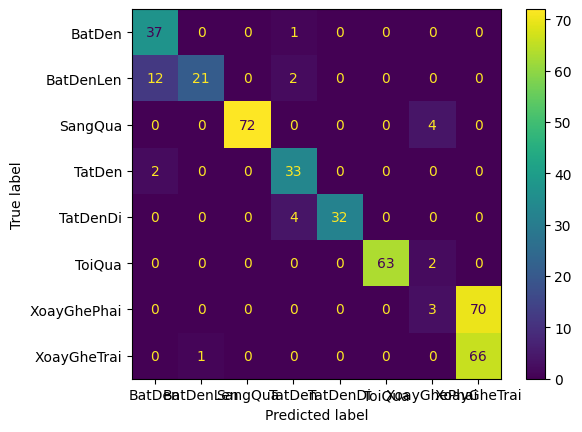

In [57]:
confusion_matrix = metrics.confusion_matrix(actual, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = labels)
cm_display.plot()
plt.show()